In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np

# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py

In [2]:
import openpathsampling.engines.toy as toys

pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(-1.0, [12.0, 12.0], [-0.5, 0.5]) +
    toys.Gaussian(-1.0, [12.0, 12.0], [-0.5, -0.5]) +
    toys.Gaussian(-1.0, [12.0, 12.0], [0.5, -0.5])
)

topology=toys.Topology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'n_steps_per_frame' : 1
}

toy_eng = toys.Engine(
    options=options,
    topology=topology
)
toy_eng.initialized = True


template = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    engine=toy_eng
)


toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

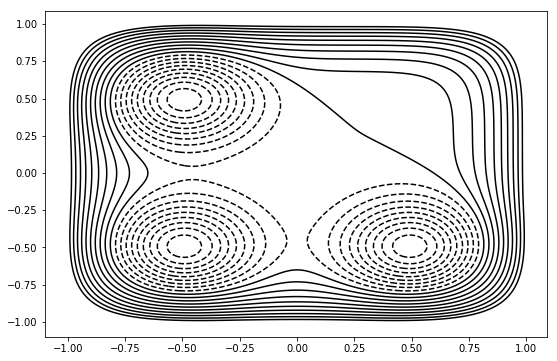

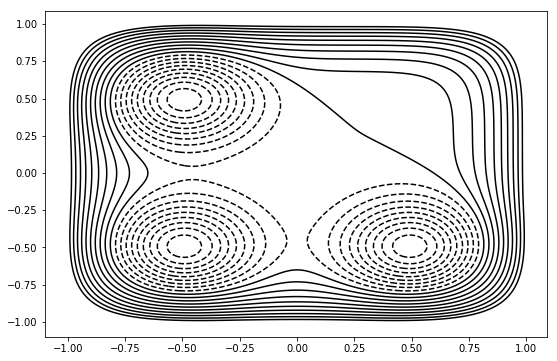

In [3]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)
plot.plot()

In [ ]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def xprime(snapshot):
    # this only exists until we set up the ability for the order parameter to decrease
    return -snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
cvX = paths.FunctionCV(name="cvX", f=xval).with_diskcache()
cvY = paths.FunctionCV(name="cvY", f=yval).with_diskcache()
cvXprime = paths.FunctionCV(name="cvXprime", f=xprime).with_diskcache()

In [ ]:
x_under_min = paths.CVDefinedVolume(cvX, float("-inf"), -0.35)
x_over_max = paths.CVDefinedVolume(cvX, 0.35, float("inf")) 
y_under_min = paths.CVDefinedVolume(cvY, float("-inf"), -0.35)
y_over_max = paths.CVDefinedVolume(cvY, 0.35, float("inf")) 

stateA = (x_under_min & y_under_min).named("A")
stateB = (x_over_max & y_under_min).named("B")
stateC = (x_under_min & y_over_max).named("C")

In [ ]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [ ]:
interfacesAB = paths.VolumeInterfaceSet(cvX, float("-inf"), [-0.35, -0.3, -0.27, -0.24, -0.2, -0.1])
interfacesAC = paths.VolumeInterfaceSet(cvY, float("-inf"), [-0.35, -0.3, -0.27, -0.24, -0.2, -0.1, 0.0])
interfacesBA = paths.VolumeInterfaceSet(cvXprime, float("-inf"), [-0.35, -0.3, -0.27, -0.24, -0.2, -0.1])

In [ ]:
ms_outer = paths.MSOuterTISInterface.from_lambdas(
    {iface: 0.0 for iface in [interfacesAB, interfacesBA]}
)
network = paths.MISTISNetwork(
    [(stateA, interfacesAB, stateB),
     (stateA, interfacesAC, stateC),
     (stateB, interfacesBA, stateA)],
    ms_outers=ms_outer,
    strict_sampling=True
)

In [ ]:
scheme = paths.DefaultScheme(network, engine=toy_eng)

In [ ]:
tisAB = network.transitions[(stateA, stateB)]
tisAC = network.transitions[(stateA, stateC)]
tisBA = network.transitions[(stateB, stateA)]

In [ ]:
import logging.config
logging.config.fileConfig("../resources/debug_logging.conf", disable_existing_loggers=False)

In [ ]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.5, 0.0]])
)
init_AB = paths.FullBootstrapping(
    transition=tisAB, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateC],
    extra_ensembles=network.ms_outers
).run()

In [ ]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.0, 0.5]])
)
init_AC = paths.FullBootstrapping(
    transition=tisAC, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateB]
).run()

In [ ]:
snapB = toys.Snapshot(
    coordinates=np.array([[0.5, -0.5]]),
    velocities=np.array([[-0.5, 0.0]])
)
init_BA = paths.FullBootstrapping(
    transition=tisBA, 
    snapshot=snapB, 
    engine=toy_eng, 
    forbidden_states=[stateC]
).run()

In [ ]:
initial_trajectories = [s.trajectory for s in list(init_AB)+list(init_AC)+list(init_BA)]

In [ ]:
plot.plot(initial_trajectories)

In [ ]:
sset = scheme.initial_conditions_from_trajectories(initial_trajectories)
print(scheme.initial_conditions_report(sset))

In [ ]:
plot.plot([s.trajectory for s in sset])

In [ ]:
minus_samples = []
for minus in network.minus_ensembles:
    samp = minus.extend_sample_from_trajectories(
        trajectories=sset,
        replica=-network.minus_ensembles.index(minus)-1,
        engine=toy_eng
    )
    minus_samples.append(samp)
print(minus_samples)
print(network.minus_ensembles)
sset = sset.apply_samples(minus_samples)
print(scheme.initial_conditions_report(sset))

In [ ]:
# The next two cells are for tests. 
# This cell creates initial conditions that will pass analysis on low data.
# The next cell undoes that to use a better initial condition in practice.
better_initial_conditions = sset

for transition in network.sampling_transitions:
    outermost_traj = sset[transition.ensembles[-1]].trajectory
    for ensemble in transition.ensembles:
        original = sset[ensemble]
        sample = paths.Sample(replica=original.replica,
                              ensemble=ensemble,
                              trajectory=outermost_traj)
        sset = sset.apply_samples(sample)

In [ ]:
#! skip
# tests should not run this, users should. Undoes the previous cell
sset = better_initial_conditions

In [ ]:
plot.plot([s.trajectory for s in sset])

In [ ]:
#logging.config.fileConfig("../resources/debug_logging.conf", disable_existing_loggers=False)
storage = paths.Storage("mistis.nc", "w")
storage.save(template)

In [ ]:
mistis_calc = paths.PathSampling(
    storage=storage,
    move_scheme=scheme,
    sample_set=sset
)
mistis_calc.save_frequency = 100

In [ ]:
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)
mistis_calc.run(100)


In [ ]:
#! skip
# skip this during testing; leave for full calculation
mistis_calc.run_until(100000)